# Anomaly Detection

In [1]:
# import sys
import sys
sys.path.append("/home/ladin/Projects/research/botnet-traffic-analysis/")

# Jupyter data visualization
from IPython import display

# data handling
from sklearn.preprocessing import normalize, Normalizer
from sklearn.utils import resample
import numpy as np
import pandas as pd

# machine learning
from sklearn.ensemble import RandomForestClassifier

# visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import plot, axis, show, pcolor, colorbar, bone
from scipy.stats import gaussian_kde

# SOM
import minisom
import somoclu
from SAD.anomaly_detection import AnomalyDetection

# hyperparameter tuning
from hyperopt import Trials, STATUS_OK, fmin, tpe, hp

# feature selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

# other
import time
import os

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [2]:
from utils.datasets import get_all_files

In [3]:
def plot_som(som, data, target=None):
    plt.figure(figsize=(16, 12))
    bone()
    pcolor(som.distance_map().T)
    colorbar()
    markers = ['o','s','D','+','v','p','*','x']
    colors = ['r','g','b','y','pink','orange','purple','grey']
    if target is not None:
        for cnt, xx in enumerate(data):
            w = som.winner(xx)
            plot(w[0]+.5, w[1]+.5, markers[target[cnt]], markerfacecolor='None',
                markeredgecolor=colors[target[cnt]], markersize=12, markeredgewidth=2)
            axis([0, som._weights.shape[0], 0, som._weights.shape[1]])
        show()
    else:
        for cnt, xx in enumerate(data):
            w = som.winner(xx)
            plot(w[0]+.5, w[1]+.5, markers[0], markerfacecolor='None',
                markeredgecolor=colors[0], markersize=12, markeredgewidth=2)
        show()

## Malware detection via Training and Tuning SOMs

In [4]:
# Load data
from utils.config import dn_nbaiot, nbaiot_1K_data_path, nbaiot_5K_data_path, nbaiot_10K_data_path, nbaiot_20K_data_path
from utils.datasets import get_all_files

In [5]:
choose_folder = nbaiot_1K_data_path
all_files = get_all_files(folder=choose_folder)

In [32]:
columns = ["MI_dir_L5_weight","MI_dir_L5_mean","MI_dir_L5_variance","MI_dir_L3_weight","MI_dir_L3_mean",
           "MI_dir_L3_variance","MI_dir_L1_weight","MI_dir_L1_mean","MI_dir_L1_variance",
           "MI_dir_L0.1_weight","MI_dir_L0.1_mean","MI_dir_L0.1_variance","MI_dir_L0.01_weight",
           "MI_dir_L0.01_mean","MI_dir_L0.01_variance","H_L5_weight","H_L5_mean","H_L5_variance",
           "H_L3_weight","H_L3_mean","H_L3_variance","H_L1_weight","H_L1_mean","H_L1_variance",
           "H_L0.1_weight","H_L0.1_mean","H_L0.1_variance","H_L0.01_weight","H_L0.01_mean",
           "H_L0.01_variance","HH_L5_weight","HH_L5_mean","HH_L5_std","HH_L5_magnitude",
           "HH_L5_radius","HH_L5_covariance","HH_L5_pcc","HH_L3_weight","HH_L3_mean",
           "HH_L3_std","HH_L3_magnitude","HH_L3_radius","HH_L3_covariance","HH_L3_pcc",
           "HH_L1_weight","HH_L1_mean","HH_L1_std","HH_L1_magnitude","HH_L1_radius",
           "HH_L1_covariance","HH_L1_pcc","HH_L0.1_weight","HH_L0.1_mean","HH_L0.1_std",
           "HH_L0.1_magnitude","HH_L0.1_radius","HH_L0.1_covariance","HH_L0.1_pcc",
           "HH_L0.01_weight","HH_L0.01_mean","HH_L0.01_std","HH_L0.01_magnitude",
           "HH_L0.01_radius","HH_L0.01_covariance","HH_L0.01_pcc","HH_jit_L5_weight",
           "HH_jit_L5_mean","HH_jit_L5_variance","HH_jit_L3_weight","HH_jit_L3_mean",
           "HH_jit_L3_variance","HH_jit_L1_weight","HH_jit_L1_mean","HH_jit_L1_variance",
           "HH_jit_L0.1_weight","HH_jit_L0.1_mean","HH_jit_L0.1_variance","HH_jit_L0.01_weight",
           "HH_jit_L0.01_mean","HH_jit_L0.01_variance","HpHp_L5_weight","HpHp_L5_mean",
           "HpHp_L5_std","HpHp_L5_magnitude","HpHp_L5_radius","HpHp_L5_covariance",
           "HpHp_L5_pcc","HpHp_L3_weight","HpHp_L3_mean","HpHp_L3_std","HpHp_L3_magnitude",
           "HpHp_L3_radius","HpHp_L3_covariance","HpHp_L3_pcc","HpHp_L1_weight","HpHp_L1_mean",
           "HpHp_L1_std","HpHp_L1_magnitude","HpHp_L1_radius","HpHp_L1_covariance","HpHp_L1_pcc",
           "HpHp_L0.1_weight","HpHp_L0.1_mean","HpHp_L0.1_std","HpHp_L0.1_magnitude",
           "HpHp_L0.1_radius","HpHp_L0.1_covariance","HpHp_L0.1_pcc","HpHp_L0.01_weight",
           "HpHp_L0.01_mean","HpHp_L0.01_std","HpHp_L0.01_magnitude","HpHp_L0.01_radius",
           "HpHp_L0.01_covariance","HpHp_L0.01_pcc"]


In [33]:
def get_data_by_device_type(index):
    device_file = [file for file in all_files if str(index) in file]
    df_benign = pd.DataFrame()
    df_ack = pd.DataFrame()
    df_scan = pd.DataFrame()
    df_syn = pd.DataFrame()
    df_udp = pd.DataFrame()
    for filename in device_file:
        df_c = pd.read_csv(os.path.join(choose_folder, filename), usecols=columns)
        rows = df_c.shape[0]
        if 'benign' in filename:
            df_benign = pd.concat([df_benign.iloc[:, :].reset_index(drop=True),
                             df_c.iloc[:rows, :].reset_index(drop=True)], axis=0)
        if 'ack' in filename:
            df_ack = pd.concat([df_ack.iloc[:, :].reset_index(drop=True),
                             df_c.iloc[:rows, :].reset_index(drop=True)], axis=0)
        if 'scan' in filename:
            df_scan = pd.concat([df_scan.iloc[:, :].reset_index(drop=True),
                             df_c.iloc[:rows, :].reset_index(drop=True)], axis=0)
        if 'syn' in filename:
            df_syn = pd.concat([df_syn.iloc[:, :].reset_index(drop=True),
                             df_c.iloc[:rows, :].reset_index(drop=True)], axis=0)
        if 'udp' in filename:
            df_udp = pd.concat([df_udp.iloc[:, :].reset_index(drop=True),
                             df_c.iloc[:rows, :].reset_index(drop=True)], axis=0)
    return df_benign, df_ack, df_scan, df_syn, df_udp
#     print(device_file)

In [89]:
df_benign, df_ack, df_scan, df_syn, df_udp = get_data_by_device_type(1)

In [90]:
df_attack = pd.concat([df_ack, df_scan, df_syn, df_udp])
df_all = pd.concat([df_benign, df_attack])

In [91]:
df_all.shape, df_benign.shape, df_attack.shape

((8000, 115), (1000, 115), (7000, 115))

In [92]:
# Normalizing
normalizer = Normalizer()
normalizer.fit(df_all.iloc[:, 0:-1])

Normalizer()

In [93]:
df_all.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_radius,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc
0,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,...,0.000000,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0
1,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,1.000000,...,34.095047,0.0,0.0,5.319895,344.262695,4.710446,344.262695,22.188299,0.0,0.0
2,1.857879,360.458980,35.789338,1.912127,360.275733,35.923972,1.969807,360.091968,35.991542,1.996939,...,100.081513,0.0,0.0,6.318264,347.703087,9.034660,347.703087,81.625077,0.0,0.0
3,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,...,0.000000,0.0,0.0,1.000000,337.000000,0.000000,337.000000,0.000000,0.0,0.0
4,1.680223,172.140917,18487.448750,1.793580,182.560279,18928.175300,1.925828,193.165753,19153.795810,1.992323,...,0.000000,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0


In [94]:
# Normalization (after fitting --> transform)

# df_all_normalized = normalizer.transform(df_all.iloc[:, 0:-1])
# df_benign_normalized = normalizer.transform(df_benign.iloc[:, 0:-1])
# df_attack_normalized = normalizer.transform(df_attack.iloc[:, 0:-1])
# df_ack_normalized = normalizer.transform(df_ack.iloc[:, 0:-1])
# df_scan_normalized = normalizer.transform(df_scan.iloc[:, 0:-1])
# df_syn_normalized = normalizer.transform(df_syn.iloc[:, 0:-1])
# df_udp_normalized = normalizer.transform(df_udp.iloc[:, 0:-1])

In [95]:
# df_all.head()
# df_all_normalized[:10]

# convert to pd.DataFrame again
# df_all_normalized = pd.DataFrame(df_all_normalized)
# df_benign_normalized = pd.DataFrame(df_benign_normalized)
# df_attack_normalized = pd.DataFrame(df_attack_normalized)
# df_ack_normalized = pd.DataFrame(df_ack_normalized)
# df_scan_normalized = pd.DataFrame(df_scan_normalized)
# df_syn_normalized = pd.DataFrame(df_syn_normalized)
# df_udp_normalized = pd.DataFrame(df_udp_normalized)

In [96]:
# preprocess data
df_benign['class'] = 0
df_ack['class'] = 1
df_scan['class'] = 2
df_syn['class'] = 3
df_udp['class'] = 4

# df_benign_normalized['class'] = 0
# df_ack_normalized['class'] = 1
# df_scan_normalized['class'] = 2
# df_syn_normalized['class'] = 3
# df_udp_normalized['class'] = 4

In [97]:
# data_benign = normalize(df_benign.iloc[:, 0:-1])
# data_ack = normalize(df_ack.iloc[:, 0:-1])
# data_scan = normalize(df_scan.iloc[:, 0:-1])
# data_syn = normalize(df_syn.iloc[:, 0:-1])
# data_udp = normalize(df_udp.iloc[:, 0:-1])

data_benign = normalizer.transform(df_benign.iloc[:, 0:-1])
data_ack = normalizer.transform(df_ack.iloc[:, 0:-1])
data_scan = normalizer.transform(df_scan.iloc[:, 0:-1])
data_syn = normalizer.transform(df_syn.iloc[:, 0:-1])
data_udp = normalizer.transform(df_udp.iloc[:, 0:-1])

In [98]:
target_benign = df_benign.iloc[:, -1].astype(int)
target_ack = df_ack.iloc[:, -1].astype(int)
target_scan = df_scan.iloc[:, -1].astype(int)
target_syn = df_syn.iloc[:, -1].astype(int)
target_udp = df_udp.iloc[:, -1].astype(int)

In [100]:
# df_benign_normalized.head()
data_benign[:1]

array([[2.97021301e-10, 1.78212781e-08, 0.00000000e+00, 2.97021301e-10,
        1.78212781e-08, 0.00000000e+00, 2.97021301e-10, 1.78212781e-08,
        0.00000000e+00, 2.97021301e-10, 1.78212781e-08, 0.00000000e+00,
        2.97021301e-10, 1.78212781e-08, 0.00000000e+00, 2.97021301e-10,
        1.78212781e-08, 0.00000000e+00, 2.97021301e-10, 1.78212781e-08,
        0.00000000e+00, 2.97021301e-10, 1.78212781e-08, 0.00000000e+00,
        2.97021301e-10, 1.78212781e-08, 0.00000000e+00, 2.97021301e-10,
        1.78212781e-08, 0.00000000e+00, 2.97021301e-10, 1.78212781e-08,
        0.00000000e+00, 1.78212781e-08, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.97021301e-10, 1.78212781e-08, 0.00000000e+00,
        1.78212781e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.97021301e-10, 1.78212781e-08, 0.00000000e+00, 1.78212781e-08,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.97021301e-10,
        1.78212781e-08, 0.00000000e+00, 1.78212781e-08, 0.000000

In [101]:
data_benign.shape, data_ack.shape, data_scan.shape

((1000, 115), (1000, 115), (2000, 115))

In [102]:
data = np.vstack([data_benign, data_ack, data_scan, data_syn, data_udp])
target = np.hstack([target_benign, target_ack, target_scan, target_syn, target_udp])

In [103]:
# shuffle
# data = resample(data)
# target = resample(target)
data, target = resample(data, target)

In [104]:
print(np.isnan(data).any())
print(np.isnan(target).any())

False
False


In [105]:
data[:1], target[:10]

(array([[4.03332835e-08, 1.77977402e-08, 3.20983417e-14, 4.62295680e-08,
         1.77978093e-08, 3.35066420e-12, 8.69808000e-08, 1.78022231e-08,
         2.13675062e-10, 6.86393769e-07, 1.78058322e-08, 3.13892379e-10,
         2.42208616e-06, 1.78048118e-08, 2.47607281e-10, 4.03332835e-08,
         1.77977402e-08, 3.20983417e-14, 4.62295680e-08, 1.77978093e-08,
         3.35066420e-12, 8.69808000e-08, 1.78022231e-08, 2.13675062e-10,
         6.86393769e-07, 1.78058322e-08, 3.13892379e-10, 2.42208616e-06,
         1.78048118e-08, 2.47607281e-10, 2.96628992e-10, 1.77977395e-08,
         0.00000000e+00, 1.77977395e-08, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 2.96628992e-10, 1.77977395e-08, 0.00000000e+00,
         1.77977395e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         2.96628992e-10, 1.77977395e-08, 0.00000000e+00, 1.77977395e-08,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.96628992e-10,
         1.77977395e-08, 0.00000000e+00, 1.77977395

In [106]:
data[:1], target[:10]

(array([[4.03332835e-08, 1.77977402e-08, 3.20983417e-14, 4.62295680e-08,
         1.77978093e-08, 3.35066420e-12, 8.69808000e-08, 1.78022231e-08,
         2.13675062e-10, 6.86393769e-07, 1.78058322e-08, 3.13892379e-10,
         2.42208616e-06, 1.78048118e-08, 2.47607281e-10, 4.03332835e-08,
         1.77977402e-08, 3.20983417e-14, 4.62295680e-08, 1.77978093e-08,
         3.35066420e-12, 8.69808000e-08, 1.78022231e-08, 2.13675062e-10,
         6.86393769e-07, 1.78058322e-08, 3.13892379e-10, 2.42208616e-06,
         1.78048118e-08, 2.47607281e-10, 2.96628992e-10, 1.77977395e-08,
         0.00000000e+00, 1.77977395e-08, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 2.96628992e-10, 1.77977395e-08, 0.00000000e+00,
         1.77977395e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         2.96628992e-10, 1.77977395e-08, 0.00000000e+00, 1.77977395e-08,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.96628992e-10,
         1.77977395e-08, 0.00000000e+00, 1.77977395

# Creating and training SOM

In [107]:
data_benign.shape

(1000, 115)

In [108]:
n = 5000
x = int(1/2*np.sqrt(n))
som_og = minisom.MiniSom(x=x,
                        y=x,
                        input_len=data_benign.shape[1],
                        sigma=2,
                        learning_rate=0.5)

In [109]:
som_og.train_random(data_benign, 100)

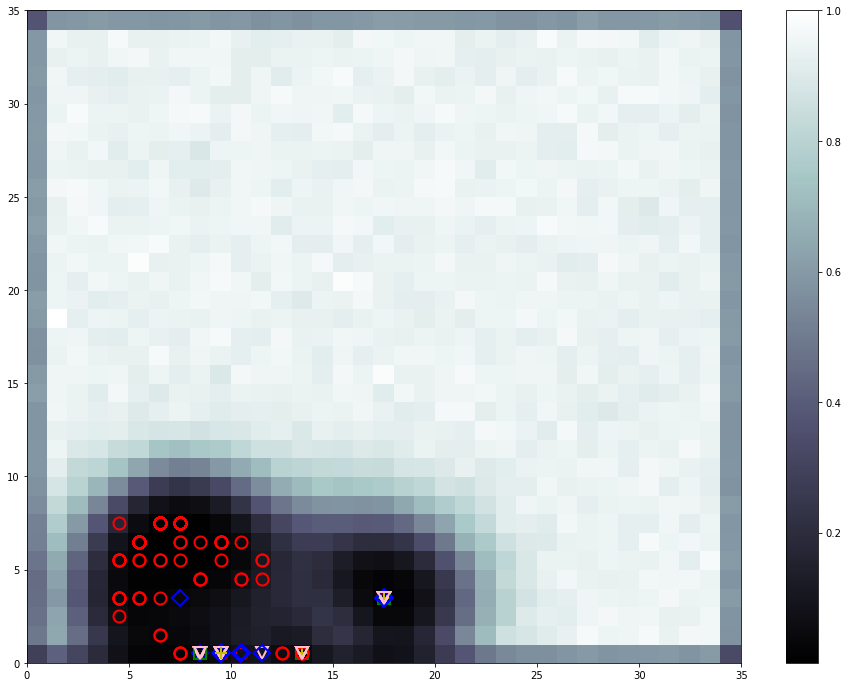

In [110]:
plot_som(som_og, data[0:n, :], target[0:n])

# Tree-based feature selection

In [111]:
clf = ExtraTreesClassifier()
clf.fit(data, target)

ExtraTreesClassifier()

In [112]:
sfm = SelectFromModel(clf, prefit=True)

In [113]:
data_benign_new = sfm.transform(data_benign)
data_ack_new = sfm.transform(data_ack)
data_scan_new = sfm.transform(data_scan)
data_syn_new = sfm.transform(data_syn)
data_udp_new = sfm.transform(data_udp)
data_new = sfm.transform(data)

In [114]:
print("Number of feature: ", data_new.shape[1])

Number of feature:  20


In [115]:
space = {
    'sigma': hp.uniform('sigma', 5, 10),
    'learning_rate': hp.uniform('learning_rate', 0.05, 5),
    'x': hp.uniform('x', 20, 50)
}

In [116]:
def som_fn(space):
    sig = space['sigma']
    learning_rate = space['learning_rate']
    x = int(space['x'])
    val = minisom.MiniSom(x=x,
                         y=x,
                         input_len=data_benign_new.shape[1],
                         sigma=sig,
                         learning_rate=learning_rate,
                         ).quantization_error(data_benign_new[0:100, :])
    print(space)
    print(val)
    return {'loss': val, 'status': STATUS_OK}

In [117]:
trials = Trials()

In [118]:
best = fmin(fn=som_fn,
           space=space,
           algo=tpe.suggest,
           max_evals=1200,
           trials=trials)

{'learning_rate': 1.2547981427392252, 'sigma': 7.881515536710804, 'x': 27.295366864105162}
1.0069628458463438                                      
{'learning_rate': 2.3209472291240303, 'sigma': 8.195925734299987, 'x': 49.06269888899942}
0.9561311939093468                                                                
{'learning_rate': 1.2605086087413278, 'sigma': 6.849641673134514, 'x': 34.269426701140105}
0.9789194037937753                                                                
{'learning_rate': 3.22010562875411, 'sigma': 7.328617121462074, 'x': 36.28613492040549}
0.9641669771409482                                                                
{'learning_rate': 3.2421814063099244, 'sigma': 6.538471558236221, 'x': 46.91879769608849}
0.9241047042280891                                                                
{'learning_rate': 0.2271990862257809, 'sigma': 9.229117937560442, 'x': 43.95944404628462}
0.9449721284464105                                                     

{'learning_rate': 1.6773841439357016, 'sigma': 6.913084403491703, 'x': 47.61702289138054}
0.9789300892041958                                                                 
{'learning_rate': 2.176484901541384, 'sigma': 7.239076805818258, 'x': 36.308945395614515}
0.9945467013939115                                                                 
{'learning_rate': 1.5129795383234905, 'sigma': 8.263543966398096, 'x': 46.18337250144234}
0.9518525403640564                                                                 
{'learning_rate': 4.631223752569903, 'sigma': 7.432657328263389, 'x': 21.295543417234676}
0.9794072394768117                                                                 
{'learning_rate': 2.757163463682502, 'sigma': 6.6646254637940014, 'x': 24.266136592726994}
0.9920655705190049                                                                 
{'learning_rate': 4.209943382543741, 'sigma': 6.335632105408274, 'x': 32.83560663174421}
0.9845557773350309                      

{'learning_rate': 2.7406508205964975, 'sigma': 5.767228463444823, 'x': 29.45319597829105}
0.977435554518741                                                                   
{'learning_rate': 3.333044578120853, 'sigma': 5.590545122687261, 'x': 33.39308020010235}
0.988588258533671                                                                   
{'learning_rate': 1.2362921378234022, 'sigma': 5.847438555338465, 'x': 38.45555318500898}
0.9287727280984348                                                                  
{'learning_rate': 3.833362887227822, 'sigma': 5.093994243129016, 'x': 31.96060898891616}
0.9651222551822827                                                                  
{'learning_rate': 2.273274424158343, 'sigma': 6.573947856179589, 'x': 28.651590578005475}
0.9863933438900807                                                                  
{'learning_rate': 2.9352668409305958, 'sigma': 6.307010610674703, 'x': 37.28800865837181}
0.9585161579186573                   

{'learning_rate': 3.822640504524098, 'sigma': 8.164886010951655, 'x': 40.98920427213398}
0.9870929081030353                                                                  
{'learning_rate': 4.641766281163281, 'sigma': 6.754615465391504, 'x': 42.3886122347385}
0.9864872574955074                                                                  
{'learning_rate': 3.5302268169072932, 'sigma': 7.94393302492168, 'x': 40.129436415064575}
0.9414554361588066                                                                  
{'learning_rate': 3.7344925307244887, 'sigma': 7.366916726497445, 'x': 43.50458490781327}
0.9543180046689963                                                                  
{'learning_rate': 3.3466890007547865, 'sigma': 5.489513239162274, 'x': 37.81781143383876}
0.9958088275401218                                                                  
{'learning_rate': 3.928573858321441, 'sigma': 6.054781852915579, 'x': 46.75027766107204}
0.954938682414253                      

{'learning_rate': 3.186386872050963, 'sigma': 8.424254178716788, 'x': 29.27623085516747}
0.9928065033723928                                                                  
{'learning_rate': 2.2741020692500076, 'sigma': 7.392243358377895, 'x': 33.63590425652482}
0.9892694251796947                                                                  
{'learning_rate': 3.105705234415504, 'sigma': 8.606910270155534, 'x': 30.881410947743387}
0.9829357123436747                                                                  
{'learning_rate': 2.8323741378580833, 'sigma': 7.7978308410751085, 'x': 32.563321137031835}
0.9840009470544909                                                                  
{'learning_rate': 3.5634997828490382, 'sigma': 8.137952379063014, 'x': 33.53180919516551}
1.0087807025435915                                                                  
{'learning_rate': 2.7142924945876796, 'sigma': 6.575592370686257, 'x': 34.31743298220292}
0.9821054928478499                

{'learning_rate': 4.594136913292353, 'sigma': 7.072574937243336, 'x': 45.350127751031415}
0.9615946854658171                                                                  
{'learning_rate': 3.5009034364007143, 'sigma': 6.339263180218454, 'x': 39.38011921675012}
0.9824839150363438                                                                  
{'learning_rate': 4.1358684879360395, 'sigma': 9.084562018240874, 'x': 36.543733584238005}
0.9734496080754362                                                                  
{'learning_rate': 4.991461478853671, 'sigma': 8.091701947933581, 'x': 33.51446824372663}
0.9773527177594166                                                                  
{'learning_rate': 4.2511496354990115, 'sigma': 8.885852885872898, 'x': 42.72475277479357}
0.9672874645840567                                                                  
{'learning_rate': 4.462381907906082, 'sigma': 8.540024278697508, 'x': 29.436788451758254}
0.9906964928516188                 

{'learning_rate': 4.507590041395208, 'sigma': 5.639568939160952, 'x': 48.483799355422164}
0.9673845915314477                                                                  
{'learning_rate': 3.6654175822314925, 'sigma': 6.151497206456243, 'x': 43.551431634996575}
0.9722854886712934                                                                  
{'learning_rate': 4.022014799711166, 'sigma': 6.438876267444879, 'x': 44.92547923704042}
0.910782888178334                                                                   
{'learning_rate': 2.4829023185943746, 'sigma': 7.13742124511983, 'x': 46.403336169514894}
0.9695455183002964                                                                  
{'learning_rate': 4.123215210653402, 'sigma': 6.97818646461904, 'x': 48.008158794230674}
0.9671593848247321                                                                  
{'learning_rate': 4.323529808746037, 'sigma': 5.363377357957411, 'x': 49.85309066034416}
0.96996932132942                     

0.9672777605915971                                                                  
{'learning_rate': 3.2227369361378124, 'sigma': 7.0641189280756755, 'x': 45.53200812961506}
0.9563993026390493                                                                  
{'learning_rate': 4.106496975470862, 'sigma': 7.221526272646994, 'x': 49.08054291792999}
0.965708562625187                                                                   
{'learning_rate': 2.752131662934782, 'sigma': 6.979202440724584, 'x': 36.16011030410953}
0.985207031607836                                                                   
{'learning_rate': 3.508432452400334, 'sigma': 6.8037130175938225, 'x': 42.18114921858957}
0.9741377644461054                                                                  
{'learning_rate': 3.80289678469903, 'sigma': 5.907279496528847, 'x': 46.974144026630036}
0.9496467286546841                                                                  
{'learning_rate': 4.6308209178379025, 'sig

0.9719318888143165                                                                  
{'learning_rate': 3.1248526281143203, 'sigma': 7.358617451847746, 'x': 47.56779826450274}
0.9320264445718953                                                                  
{'learning_rate': 3.5183246700569173, 'sigma': 6.588561482808954, 'x': 41.80123621191005}
0.9355149131635302                                                                  
{'learning_rate': 2.659857251867295, 'sigma': 8.067893550901381, 'x': 45.09897142385964}
0.9688855286148139                                                                  
{'learning_rate': 3.744010089652609, 'sigma': 7.568036585263995, 'x': 35.061921573559914}
0.94786796524422                                                                    
{'learning_rate': 3.5302642582407064, 'sigma': 6.888700094934999, 'x': 46.7471202135961}
0.9564350322552205                                                                  
{'learning_rate': 4.173881963322183, 'sigm

0.9174863515198406                                                                  
{'learning_rate': 2.9763662388455803, 'sigma': 7.421374407649172, 'x': 33.8245787289042}
0.9987571292485152                                                                  
{'learning_rate': 4.074058590233105, 'sigma': 6.236236572858672, 'x': 48.94938928458198}
0.987245432019296                                                                   
{'learning_rate': 3.5322501012539, 'sigma': 6.960069022580059, 'x': 47.92206390670016}
0.9487631130741573                                                                  
{'learning_rate': 3.2389779720984224, 'sigma': 6.832355558700445, 'x': 45.40957559486243}
0.9651561865134876                                                                  
{'learning_rate': 2.8013859797779435, 'sigma': 6.378584760721401, 'x': 46.56998414692356}
0.9560129427200718                                                                  
{'learning_rate': 3.131173072831614, 'sigma':

0.9780185144114004                                                                  
{'learning_rate': 4.202362918980631, 'sigma': 6.886114874303471, 'x': 36.87499095856324}
0.9726539318157247                                                                  
{'learning_rate': 3.8899883568344364, 'sigma': 7.15940705167716, 'x': 49.97068069963967}
0.9353265782111564                                                                  
{'learning_rate': 3.3022112337317995, 'sigma': 6.115348777808056, 'x': 41.464210265428484}
0.9921501593521225                                                                  
{'learning_rate': 2.962309873250496, 'sigma': 7.422900497900433, 'x': 48.31287156928188}
0.9536456127936666                                                                  
{'learning_rate': 3.6215094268203045, 'sigma': 7.796652109959438, 'x': 42.24012714423775}
0.9532908546294153                                                                  
{'learning_rate': 4.011006979841634, 'sigm

0.9465351732710832                                                                   
{'learning_rate': 4.794001266556264, 'sigma': 8.55594981558223, 'x': 45.01468553261227}
0.9700518726654568                                                                   
{'learning_rate': 4.512225965368629, 'sigma': 8.10686008852671, 'x': 43.67727139697638}
0.9666365996600033                                                                   
{'learning_rate': 4.730335632249842, 'sigma': 7.270008994697736, 'x': 46.2126041326488}
0.9597553805236454                                                                   
{'learning_rate': 4.86640537062455, 'sigma': 8.791545870675868, 'x': 44.54401744054097}
0.9700031269447552                                                                   
{'learning_rate': 4.585594077000383, 'sigma': 7.7776013445004715, 'x': 43.78613060630421}
0.9796773703528594                                                                   
{'learning_rate': 4.903073293095477, 'sigm

0.9500340365843347                                                                   
{'learning_rate': 3.810548470086175, 'sigma': 8.525393107767592, 'x': 45.38664887971351}
0.9595550806277662                                                                   
{'learning_rate': 4.9992635662761815, 'sigma': 8.854135524469259, 'x': 46.81634724392238}
0.9558011367934184                                                                   
{'learning_rate': 4.4059325207620805, 'sigma': 8.014321277979791, 'x': 42.071976825135515}
0.98388222554733                                                                     
{'learning_rate': 4.090229360003015, 'sigma': 8.158080162372407, 'x': 49.92157331721451}
0.9496183551962598                                                                   
{'learning_rate': 4.632290889148865, 'sigma': 8.243941152472551, 'x': 49.03423987018615}
0.9625474890040651                                                                   
{'learning_rate': 3.5404759706074493

In [119]:
print('Best: {}'.format(best))

Best: {'learning_rate': 3.7590354458419775, 'sigma': 7.494967451991574, 'x': 44.79496634959443}


In [120]:
som_turned = minisom.MiniSom(x=int(best['x']),
                            y=int(best['x']),
                            input_len=data_benign_new.shape[1],
                            sigma=best['sigma'],
                            learning_rate=best['learning_rate'])

In [121]:
som_turned.train_random(data_benign_new, 1000)

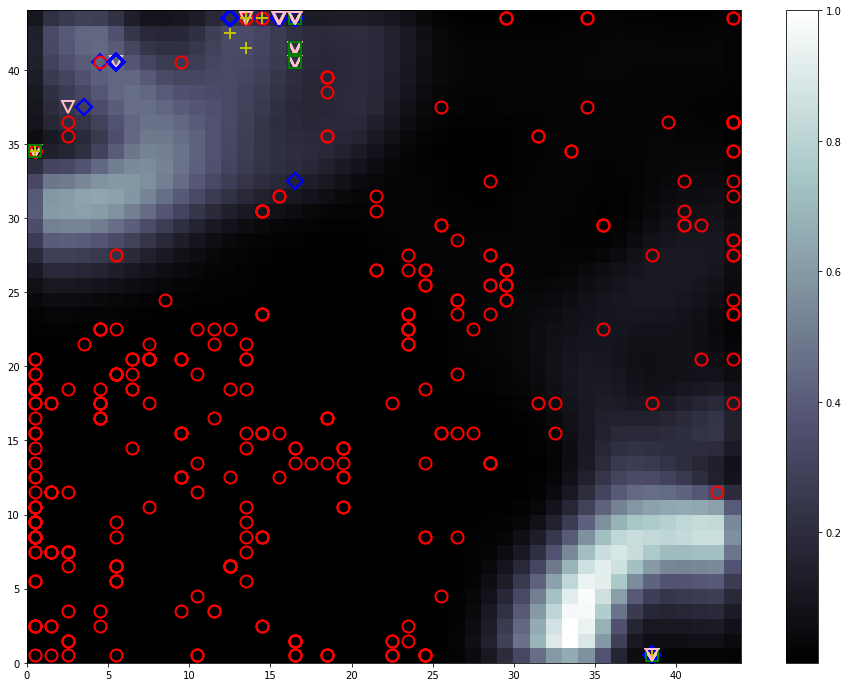

In [122]:
n = 10000
plot_som(som_turned, data_new[0:n, :], target[0:n])

## Somoclu

Flexible library with many options.

Pros:
- easy to identify clusters
- PCA initialization instead of random
- includes K-means clustering algorithm from sklearn
- evolving maps

Cons:
- long time to train.

In [124]:
som_somoclu = somoclu.Somoclu(n_columns=45,
                             n_rows=45,
                             std_coeff=7.5,
                             verbose=1)

In [125]:
som_somoclu.train(data_new[0:1000, :],
                 scale0=0.2,
                 scaleN=0.02)

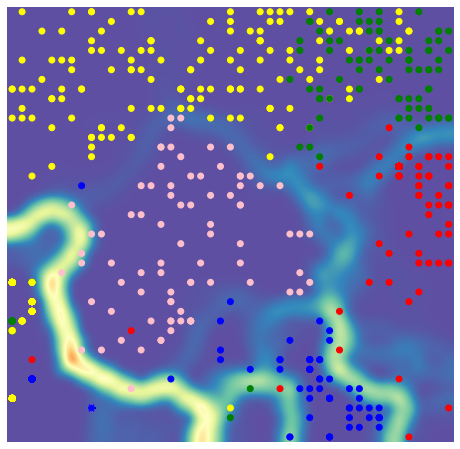

<module 'matplotlib.pyplot' from '/home/ladin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [126]:
colors = ['red', 'green', 'blue', 'pink', 'yellow']
color_list = [colors[t] for t in target[0:1000]]
som_somoclu.view_umatrix(bestmatches=True, bestmatchcolors=color_list)

# Anomaly detection with SOM and K-nearest neighbors

In [127]:
def get_anomalies(benign_metrics, anomaly_metrics, alpha=3, return_outliers=True):
    '''
    Get anomalies from evaluation metric
    '''
    limit = np.mean(benign_metrics)+np.std(benign_metrics)*alpha
    outliers = np.argwhere(np.abs(anomaly_metrics) > limit)
    print("Determined: ", len(outliers)/len(anomaly_metrics)*100, "% as anomaly")
    if return_outliers:
        return outliers

In [128]:
def minimize_anomaly(benign_metrics, anomaly_metrics, alpha=3):
    '''
    Objective function to be minimized durinig tuning
    calculates percent error in classifying anomalies based on steady state metrics.
    '''
    limit = np.mean(benign_metrics) + np.std(benign_metrics)*alpha
    outliers = np.argwhere(np.abs(anomaly_metrics)>limit)
    pct_anomaly = len(outliers)/len(anomaly_metrics)
    return 1 - pct_anomaly

In [129]:
# print(minimize_anomaly(benign_metrics=benign_metrics, anomaly_metrics=anomaly_metrics))

In [130]:
training = data_benign_new
evaluation = data_new

In [131]:
# initialize our anomaly detector with some arbitrary parameters
anomaly_detector = AnomalyDetection(shape=(10,10),
                                   input_size=training.shape[1],
                                   learning_rate=8,
                                   learning_decay=0.001,
                                   initial_radius=2,
                                   radius_decay=0.001,
                                   min_number_per_bmu=0,
                                   number_of_neighbors=3)
# fit the anomaly detector and apply to the evaluation data
anomaly_detector.fit(training, 5000)

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]


array([[9.34721702e-08, 1.30546631e-06, 2.06278772e-07, ...,
        4.22571695e-02, 1.94714642e-05, 9.97583622e-01],
       [6.18733773e-08, 1.46960476e-06, 1.30567967e-07, ...,
        2.93134570e-02, 3.61266910e-06, 9.99302219e-01],
       [1.59944421e-06, 9.09253926e-05, 5.55418285e-06, ...,
        2.28385860e-02, 1.96330010e-05, 9.99690472e-01],
       ...,
       [2.27252163e-09, 3.09815723e-08, 3.53185585e-09, ...,
        1.65644221e-04, 1.44972037e-06, 9.99920892e-01],
       [9.01106877e-10, 1.62382171e-08, 1.58006709e-09, ...,
        5.88453480e-06, 1.16632540e-08, 9.99999999e-01],
       [1.59918738e-09, 2.52237151e-08, 2.68019316e-09, ...,
        2.49768376e-07, 2.11158952e-08, 1.00000000e+00]])

In [132]:
# set limits
benign_metrics = anomaly_detector.evaluate(data_benign_new)
alpha = 3
sd_benign = np.std(benign_metrics)
mean_benign = np.mean(benign_metrics)
lim_benign = mean_benign + alpha*sd_benign
pct_benign = np.percentile(benign_metrics, 99.7)

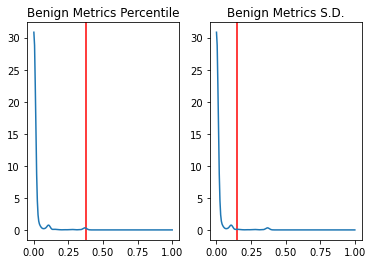

In [133]:
# visualizing benign
density = gaussian_kde(benign_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Benign Metrics Percentile")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Benign Metrics S.D.")
plt.show()

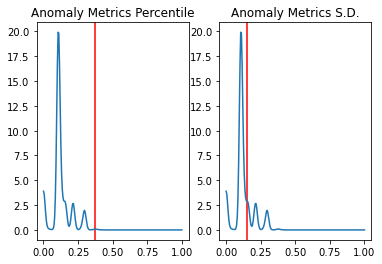

In [134]:
# Visualizing all anomalies
anomaly_metrics = anomaly_detector.evaluate(evaluation)
density = gaussian_kde(anomaly_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Anomaly Metrics Percentile")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Anomaly Metrics S.D.")
plt.show()

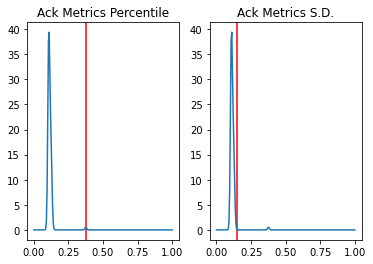

In [135]:
# Visualizing all anomalies
ack_metrics = anomaly_detector.evaluate(data_ack_new)
density = gaussian_kde(ack_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Ack Metrics Percentile")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Ack Metrics S.D.")
plt.show()

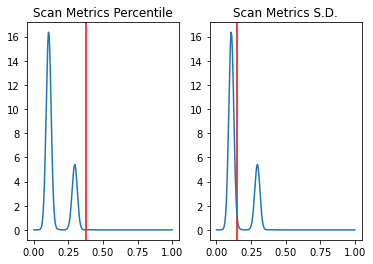

In [136]:
# Visualizing all anomalies
scan_metrics = anomaly_detector.evaluate(data_scan_new)
density = gaussian_kde(scan_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Scan Metrics Percentile")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Scan Metrics S.D.")
plt.show()

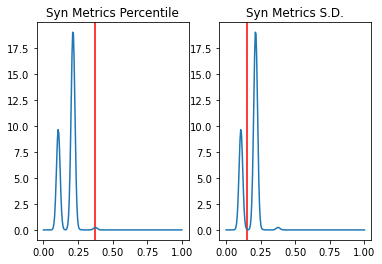

In [137]:
# Visualizing all anomalies
syn_metrics = anomaly_detector.evaluate(data_syn_new)
density = gaussian_kde(syn_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Syn Metrics Percentile")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Syn Metrics S.D.")
plt.show()

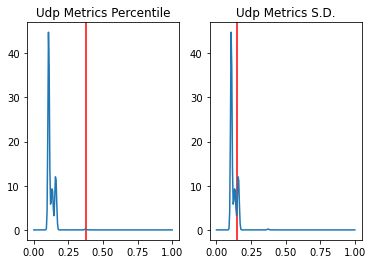

In [138]:
# Visualizing all anomalies
udp_metrics = anomaly_detector.evaluate(data_udp_new)
density = gaussian_kde(udp_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Udp Metrics Percentile")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Udp Metrics S.D.")
plt.show()

In [139]:
metrics = [benign_metrics, anomaly_metrics, ack_metrics, scan_metrics, syn_metrics, udp_metrics]
metric_names = ['benign', 'all alnomalies', 'ack', 'scan', 'syn', 'udp']
alpha = 3
for metric, name in zip(metrics, metric_names):
    print(name)
    get_anomalies(benign_metrics, metric, alpha, False)

benign
Determined:  1.9 % as anomaly
all alnomalies
Determined:  22.2 % as anomaly
ack
Determined:  0.8999999999999999 % as anomaly
scan
Determined:  25.75 % as anomaly
syn
Determined:  67.80000000000001 % as anomaly
udp
Determined:  20.633333333333333 % as anomaly


# Hyperparameter tuning

In [140]:
import time
start_time = time.time()

space = {
    'n_neighbors': hp.uniform('n_neighbors', 1, 3),
    'learning_rate': hp.uniform('learning_rate', 0.005, 10),
    'learning_decay': hp.uniform('learning_decay', 0.00001, 0.1),
    'initial_radius': hp.uniform('initial_radius', 1, 10),
    'radius_decay': hp.uniform('radius_decay', 0.00001, 0.1),
    'x': hp.uniform('x', 10, 50),
    'minNumberPerBmu': hp.uniform('minNumberPerBmu', 0, 10)
}

In [141]:
def anomaly_fn(space):
    n_neighbors = int(space['n_neighbors'])
    learning_rate = space['learning_rate']
    learning_decay = space['learning_decay']
    initial_radius = int(space['initial_radius'])
    radius_decay = space['radius_decay']
    x = int(space['x'])
    minNumberPerBmu = int(space['minNumberPerBmu'])
    
    anomaly_detector = AnomalyDetection(shape=(x, x),
                                       input_size=training.shape[1],
                                       learning_rate=learning_rate,
                                       learning_decay=learning_decay,
                                       initial_radius=initial_radius,
                                       radius_decay=radius_decay,
                                       min_number_per_bmu=minNumberPerBmu,
                                       number_of_neighbors=n_neighbors)
    anomaly_detector.fit(training, 5000)
    a_metrics = anomaly_detector.evaluate(evaluation)
    b_metrics = anomaly_detector.evaluate(training)
    val = minimize_anomaly(b_metrics, a_metrics, alpha=3)
    
    print(space)
    print(val)
    return {'loss': val, 'status': STATUS_OK}

In [142]:
trials = Trials()
best = fmin(fn=anomaly_fn,
           space=space,
           algo=tpe.suggest,
           max_evals=100,
           trials=trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.419191611001338, 'learning_decay': 0.02908945681608694, 'learning_rate': 5.224884716347023, 'minNumberPerBmu': 6.895646547938229, 'n_neighbors': 1.301900334648953, 'radius_decay': 0.03094778547939693, 'x': 29.071795951717654}
0.11912500000000004                                    
  1%|          | 1/100 [00:03<06:13,  3.77s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.6807449893966755, 'learning_decay': 0.07002086968263602, 'learning_rate': 4.42404760268885, 'minNumberPerBmu': 9.529323505083042, 'n_neighbors': 1.9083146824147137, 'radius_decay': 0.07280610940048093, 'x': 21.841663207227498}
0.49475                                                                           
  2%|▏         | 2/100 [00:06<05:07,  3.14s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.2783974784264802, 'learning_decay': 0.09635468825028015, 'learning_rate': 7.6732825786383945, 'minNumberPerBmu': 3.4231707171795, 'n_neighbors': 2.0323223892278195, 'radius_decay': 0.02370162760947592, 'x': 12.419669202639385}
0.431125                                                                          
  3%|▎         | 3/100 [00:08<04:06,  2.54s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.142386274362714, 'learning_decay': 0.07435283653794672, 'learning_rate': 5.286065560358951, 'minNumberPerBmu': 3.785899349141678, 'n_neighbors': 1.5019969103230593, 'radius_decay': 0.08274516984982337, 'x': 22.699500671890252}
0.431125                                                                          
  4%|▍         | 4/100 [00:11<04:13,  2.64s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.086939906803046, 'learning_decay': 0.041606409941198456, 'learning_rate': 4.003196703224409, 'minNumberPerBmu': 5.259216871231935, 'n_neighbors': 1.1361391166098056, 'radius_decay': 0.050884584233635066, 'x': 20.70059306871959}
0.437875                                                                          
  5%|▌         | 5/100 [00:14<04:33,  2.88s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.398328829503961, 'learning_decay': 0.039338466140281025, 'learning_rate': 5.369568932416782, 'minNumberPerBmu': 3.0159157238463896, 'n_neighbors': 2.0180324247045043, 'radius_decay': 0.03132879395459061, 'x': 46.656834326966546}
0.34962499999999996                                                               
  6%|▌         | 6/100 [00:21<06:56,  4.43s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.707050936697362, 'learning_decay': 0.0846206455590994, 'learning_rate': 5.9410252828417205, 'minNumberPerBmu': 2.810238149018315, 'n_neighbors': 1.6729767189827993, 'radius_decay': 0.0960817649775457, 'x': 29.56451636913886}
0.49187499999999995                                                               
  7%|▋         | 7/100 [00:25<06:31,  4.21s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.770386224007621, 'learning_decay': 0.056165328330245394, 'learning_rate': 7.836310345709944, 'minNumberPerBmu': 5.946696415944091, 'n_neighbors': 1.0849127940634675, 'radius_decay': 0.05927622798941519, 'x': 33.16169209947698}
0.622                                                                             
  8%|▊         | 8/100 [00:30<06:38,  4.33s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.47820611819371, 'learning_decay': 0.015774421948422202, 'learning_rate': 2.2063390138660677, 'minNumberPerBmu': 2.194234522182219, 'n_neighbors': 2.4457375569501023, 'radius_decay': 0.04692234028155208, 'x': 41.798807212854555}
0.43762500000000004                                                               
  9%|▉         | 9/100 [00:36<07:26,  4.91s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.207537530053555, 'learning_decay': 0.07273107600929983, 'learning_rate': 1.603963695437622, 'minNumberPerBmu': 1.110205706127606, 'n_neighbors': 2.4495298797339453, 'radius_decay': 0.02382607155197801, 'x': 32.68132180494442}
0.43100000000000005                                                               
 10%|█         | 10/100 [00:41<07:16,  4.85s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.925772943494546, 'learning_decay': 0.03228208621845606, 'learning_rate': 4.314765088273783, 'minNumberPerBmu': 7.205790895733346, 'n_neighbors': 2.7162449601452447, 'radius_decay': 0.0940314779960813, 'x': 42.86838831816594}
0.431125                                                                           
 11%|█         | 11/100 [00:47<07:54,  5.33s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.0611671772496676, 'learning_decay': 0.03832278627688388, 'learning_rate': 8.821319758000579, 'minNumberPerBmu': 5.770490959760304, 'n_neighbors': 1.889289071452556, 'radius_decay': 0.03790998707445371, 'x': 40.69605897338397}
0.43100000000000005                                                                
 12%|█▏        | 12/100 [00:53<08:09,  5.56s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.03534737040544, 'learning_decay': 0.05311375992526285, 'learning_rate': 2.2953112231883765, 'minNumberPerBmu': 6.658242564439648, 'n_neighbors': 1.232944508129954, 'radius_decay': 0.08064085914286837, 'x': 38.474008159083965}
0.35324999999999995                                                                
 13%|█▎        | 13/100 [00:59<08:02,  5.54s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.685815971633655, 'learning_decay': 0.04185641460983133, 'learning_rate': 1.8691109127428294, 'minNumberPerBmu': 1.5272993436874926, 'n_neighbors': 2.717567155958611, 'radius_decay': 0.02894795391925798, 'x': 41.92085039135965}
0.34962499999999996                                                                
 14%|█▍        | 14/100 [01:05<08:20,  5.81s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.768548202611451, 'learning_decay': 0.09652077129884383, 'learning_rate': 9.71231022274422, 'minNumberPerBmu': 2.9488629468180774, 'n_neighbors': 1.5732457624448275, 'radius_decay': 0.04817650628548592, 'x': 49.43110949272569}
0.7295                                                                             
 15%|█▌        | 15/100 [01:14<09:41,  6.84s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.5079361638206181, 'learning_decay': 0.030396158934753423, 'learning_rate': 1.8215881472845603, 'minNumberPerBmu': 0.21985188541496115, 'n_neighbors': 1.3941359658096262, 'radius_decay': 0.08164242946119961, 'x': 36.05079412423794}
0.43100000000000005                                                                
 16%|█▌        | 16/100 [01:21<09:28,  6.77s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.402257312463638, 'learning_decay': 0.048185477211586315, 'learning_rate': 8.126206843117963, 'minNumberPerBmu': 1.701393894910076, 'n_neighbors': 2.062764548558718, 'radius_decay': 0.018789590198209437, 'x': 29.80188174164614}
0.27337500000000003                                                                
 17%|█▋        | 17/100 [01:25<08:04,  5.84s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.7689799268774298, 'learning_decay': 0.09647404005489735, 'learning_rate': 5.851703404349211, 'minNumberPerBmu': 3.0859965098962205, 'n_neighbors': 1.4486449342757193, 'radius_decay': 0.07051909938131525, 'x': 25.55195739144679}
0.49187499999999995                                                                
 18%|█▊        | 18/100 [01:28<06:58,  5.11s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.610728745542504, 'learning_decay': 0.06823814403878449, 'learning_rate': 9.154520799079766, 'minNumberPerBmu': 6.267631180739238, 'n_neighbors': 1.326004046053172, 'radius_decay': 0.0270461411026631, 'x': 23.743510593571187}
0.34962499999999996                                                                
 19%|█▉        | 19/100 [01:31<05:59,  4.44s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.611885315852321, 'learning_decay': 0.023766683698076236, 'learning_rate': 6.938985334408185, 'minNumberPerBmu': 0.4159883128828057, 'n_neighbors': 1.773472641877905, 'radius_decay': 0.055394669568695695, 'x': 10.345349780062008}
0.37525                                                                            
 20%|██        | 20/100 [01:33<04:48,  3.61s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.4105542717818125, 'learning_decay': 0.006753504007808629, 'learning_rate': 3.4524330541512462, 'minNumberPerBmu': 8.519306513072861, 'n_neighbors': 2.3278880707544114, 'radius_decay': 0.0073064116128390005, 'x': 17.768238359787063}
0.43100000000000005                                                                
 21%|██        | 21/100 [01:35<04:13,  3.21s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.048744634372397, 'learning_decay': 0.005321215791656696, 'learning_rate': 0.532384566284926, 'minNumberPerBmu': 7.936723340525936, 'n_neighbors': 2.2207602015825376, 'radius_decay': 0.0003906320165928609, 'x': 28.14835435150599}
0.34924999999999995                                                                
 22%|██▏       | 22/100 [01:38<04:19,  3.32s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.590937782965585, 'learning_decay': 0.020439692984519028, 'learning_rate': 6.78721508150715, 'minNumberPerBmu': 4.398146178170267, 'n_neighbors': 2.187324958130755, 'radius_decay': 0.014046931176469643, 'x': 16.590584769512347}
0.29600000000000004                                                                
 23%|██▎       | 23/100 [01:41<03:49,  2.98s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.9414021441063896, 'learning_decay': 0.05956845044041971, 'learning_rate': 8.383692730843414, 'minNumberPerBmu': 9.88442465769536, 'n_neighbors': 2.8812364574181313, 'radius_decay': 0.014858130225640503, 'x': 34.18894549297049}
0.430875                                                                           
 24%|██▍       | 24/100 [01:45<04:26,  3.51s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.406553711082956, 'learning_decay': 0.04897809723790863, 'learning_rate': 6.931086285142076, 'minNumberPerBmu': 4.587706907161669, 'n_neighbors': 1.7804172906363516, 'radius_decay': 0.04005042954297565, 'x': 28.398589946987745}
0.49187499999999995                                                                
 25%|██▌       | 25/100 [01:49<04:27,  3.56s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.276488485803773, 'learning_decay': 0.012473928585298194, 'learning_rate': 3.186385194180627, 'minNumberPerBmu': 8.803788644692435, 'n_neighbors': 1.0217676952735477, 'radius_decay': 0.0004146852806518539, 'x': 26.095723539333942}
0.621375                                                                           
 26%|██▌       | 26/100 [01:52<04:16,  3.47s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.785916327570769, 'learning_decay': 0.00024337437817819468, 'learning_rate': 6.508356218482093, 'minNumberPerBmu': 7.209739962181622, 'n_neighbors': 2.199314312013802, 'radius_decay': 0.01567922829230184, 'x': 31.965349857436053}
0.34950000000000003                                                                
 27%|██▋       | 27/100 [01:56<04:26,  3.65s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.183820594638806, 'learning_decay': 0.02845275325801786, 'learning_rate': 9.964626333068736, 'minNumberPerBmu': 5.24489245444147, 'n_neighbors': 2.577353368750143, 'radius_decay': 0.006827476828972334, 'x': 37.36508958077847}
0.34924999999999995                                                                
 28%|██▊       | 28/100 [02:02<04:56,  4.12s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.024323683708133, 'learning_decay': 0.06379451282544964, 'learning_rate': 4.909560561376913, 'minNumberPerBmu': 9.027417239475405, 'n_neighbors': 1.9058877880644212, 'radius_decay': 0.03605121754565803, 'x': 16.263263791613422}
0.49187499999999995                                                                
 29%|██▉       | 29/100 [02:04<04:13,  3.57s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.7075716362008735, 'learning_decay': 0.05036921795455659, 'learning_rate': 7.887840684232802, 'minNumberPerBmu': 7.728390696339995, 'n_neighbors': 1.6667559683893376, 'radius_decay': 0.06508336452145533, 'x': 19.97000489504382}
0.430875                                                                           
 30%|███       | 30/100 [02:06<03:46,  3.24s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.779682067986861, 'learning_decay': 0.04674893059891836, 'learning_rate': 2.981489461597805, 'minNumberPerBmu': 2.0769552959466178, 'n_neighbors': 2.085012318165428, 'radius_decay': 0.016779210464222528, 'x': 26.358732765601925}
0.34924999999999995                                                                
 31%|███       | 31/100 [02:10<03:44,  3.26s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.2393393313030274, 'learning_decay': 0.07849950599731305, 'learning_rate': 0.9308470210427178, 'minNumberPerBmu': 4.0387091370167765, 'n_neighbors': 1.8491898305774974, 'radius_decay': 0.02073718156241041, 'x': 31.34460201620534}
0.39237500000000003                                                                
 32%|███▏      | 32/100 [02:14<04:00,  3.53s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.833929976145789, 'learning_decay': 0.03487127618225281, 'learning_rate': 4.735592893750019, 'minNumberPerBmu': 9.429261331707583, 'n_neighbors': 1.1951628098365445, 'radius_decay': 0.006918317045776029, 'x': 13.157012952109667}
0.621                                                                              
 33%|███▎      | 33/100 [02:16<03:22,  3.02s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.597980077937013, 'learning_decay': 0.023306804349197484, 'learning_rate': 3.8016786158386306, 'minNumberPerBmu': 3.7067970957016803, 'n_neighbors': 1.5837429329744737, 'radius_decay': 0.04329249020657931, 'x': 23.05895868160097}
0.43100000000000005                                                                
 34%|███▍      | 34/100 [02:19<03:19,  3.02s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.7098259500494337, 'learning_decay': 0.06272663335164697, 'learning_rate': 7.346470831855639, 'minNumberPerBmu': 0.7502562044507508, 'n_neighbors': 2.9431656448504357, 'radius_decay': 0.03327103367695284, 'x': 34.902528423860794}
0.431125                                                                           
 35%|███▌      | 35/100 [02:24<03:57,  3.65s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.371409094532913, 'learning_decay': 0.07965117719181294, 'learning_rate': 6.209484003678468, 'minNumberPerBmu': 5.100470392699876, 'n_neighbors': 1.9864857549774881, 'radius_decay': 0.056040327036102004, 'x': 19.431593006118423}
0.49224999999999997                                                                
 36%|███▌      | 36/100 [02:26<03:31,  3.31s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.972959341981263, 'learning_decay': 0.08942318036238264, 'learning_rate': 5.629282262860298, 'minNumberPerBmu': 1.8904200799226292, 'n_neighbors': 2.069876601723732, 'radius_decay': 0.02145216942970785, 'x': 44.8081915006331}
0.43762500000000004                                                                
 37%|███▋      | 37/100 [02:33<04:39,  4.43s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.3043506569194445, 'learning_decay': 0.014316788599059223, 'learning_rate': 8.218311412930758, 'minNumberPerBmu': 6.9936623051216396, 'n_neighbors': 1.671154737434567, 'radius_decay': 0.01110682083695948, 'x': 38.760344959879724}
0.621625                                                                           
 38%|███▊      | 38/100 [02:39<04:54,  4.75s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.315027457385768, 'learning_decay': 0.04381652711934517, 'learning_rate': 9.489584868801476, 'minNumberPerBmu': 8.055639253586726, 'n_neighbors': 2.3780615173793365, 'radius_decay': 0.02672652250696895, 'x': 30.656389031863863}
0.431125                                                                           
 39%|███▉      | 39/100 [02:43<04:36,  4.54s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.098849033056749, 'learning_decay': 0.03674186425014608, 'learning_rate': 5.091515505246766, 'minNumberPerBmu': 2.56189326966887, 'n_neighbors': 1.331923078587829, 'radius_decay': 0.03340494367995367, 'x': 29.029364213236185}
0.353                                                                              
 40%|████      | 40/100 [02:47<04:27,  4.46s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.812299288153526, 'learning_decay': 0.05809903166762041, 'learning_rate': 7.544090462090774, 'minNumberPerBmu': 5.7962065268130685, 'n_neighbors': 2.554344945072199, 'radius_decay': 0.04300898459705641, 'x': 49.759434023654286}
0.43100000000000005                                                                
 41%|████      | 41/100 [02:57<05:52,  5.98s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.278673213246387, 'learning_decay': 0.06850541657498037, 'learning_rate': 8.692991983460455, 'minNumberPerBmu': 6.281655080649546, 'n_neighbors': 1.1011069719549234, 'radius_decay': 0.05132237922798735, 'x': 21.305656095400433}
0.7175                                                                             
 42%|████▏     | 42/100 [02:59<04:52,  5.05s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.3879910594618545, 'learning_decay': 0.028429320548343823, 'learning_rate': 4.164631686186098, 'minNumberPerBmu': 4.594385068205073, 'n_neighbors': 1.016756575649448, 'radius_decay': 0.061506624402570216, 'x': 14.391790526778149}
0.431125                                                                           
 43%|████▎     | 43/100 [03:01<03:55,  4.13s/trial, best loss: 0.11912500000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.490936377100264, 'learning_decay': 0.0183122202340358, 'learning_rate': 5.399786935655241, 'minNumberPerBmu': 1.048538708003837, 'n_neighbors': 1.4957745057925926, 'radius_decay': 0.02002619927193364, 'x': 46.478034294285145}
0.11650000000000005                                                                
 44%|████▍     | 44/100 [03:10<05:10,  5.54s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.18888833075562, 'learning_decay': 0.0008553164277672679, 'learning_rate': 5.571614888678037, 'minNumberPerBmu': 3.49106400731033, 'n_neighbors': 1.522623097856182, 'radius_decay': 0.08735708252454669, 'x': 46.04077539416819}
0.777625                                                                           
 45%|████▌     | 45/100 [03:18<05:42,  6.23s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.504786466207976, 'learning_decay': 0.020925037973298023, 'learning_rate': 4.627480535862875, 'minNumberPerBmu': 1.2583506097702324, 'n_neighbors': 1.2141131810321497, 'radius_decay': 0.0304619826541492, 'x': 47.92371404315457}
0.49187499999999995                                                                
 46%|████▌     | 46/100 [03:26<06:10,  6.86s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.6368555755616665, 'learning_decay': 0.005928355183084873, 'learning_rate': 2.2796965594898317, 'minNumberPerBmu': 5.525315889353653, 'n_neighbors': 1.350078290116132, 'radius_decay': 0.023627797923548854, 'x': 43.67122730039085}
0.3415                                                                             
 47%|████▋     | 47/100 [03:33<05:59,  6.79s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.0184546115717006, 'learning_decay': 0.01671798916187421, 'learning_rate': 2.771028186155581, 'minNumberPerBmu': 7.536696350260999, 'n_neighbors': 1.457034298287727, 'radius_decay': 0.0023553856965483483, 'x': 24.204918318911286}
0.621625                                                                           
 48%|████▊     | 48/100 [03:36<04:54,  5.66s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.986788048052759, 'learning_decay': 0.008198029997003059, 'learning_rate': 3.7311141691279683, 'minNumberPerBmu': 6.63938925619799, 'n_neighbors': 1.7531534102817763, 'radius_decay': 0.07723099487876413, 'x': 38.85887670865862}
0.6725                                                                             
 49%|████▉     | 49/100 [03:42<04:51,  5.72s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.80704285026492, 'learning_decay': 0.05418090995281927, 'learning_rate': 6.126669810502272, 'minNumberPerBmu': 2.5603728045643965, 'n_neighbors': 1.150361227257326, 'radius_decay': 0.04361224268817545, 'x': 41.26214002395516}
0.6212500000000001                                                                 
 50%|█████     | 50/100 [03:49<05:01,  6.03s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.587904900139312, 'learning_decay': 0.02611553992662442, 'learning_rate': 5.236988525841463, 'minNumberPerBmu': 0.09107129369733513, 'n_neighbors': 1.2608024194907579, 'radius_decay': 0.04999489036203619, 'x': 36.64215457984959}
0.8405                                                                             
 51%|█████     | 51/100 [03:55<04:52,  5.97s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.8802626617547817, 'learning_decay': 0.04027537323024809, 'learning_rate': 1.3768370404244754, 'minNumberPerBmu': 9.964109824584472, 'n_neighbors': 1.6117908019326515, 'radius_decay': 0.06879183792658193, 'x': 40.27815137803583}
0.430875                                                                           
 52%|█████▏    | 52/100 [04:01<04:47,  5.99s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.894676075035889, 'learning_decay': 0.03332317855868208, 'learning_rate': 4.399677187889672, 'minNumberPerBmu': 6.152548572682921, 'n_neighbors': 1.4271745486205365, 'radius_decay': 0.036685294992695516, 'x': 10.677264139937371}
0.431125                                                                           
 53%|█████▎    | 53/100 [04:02<03:41,  4.70s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.0013069373879375, 'learning_decay': 0.010359790649849978, 'learning_rate': 0.0351661703944135, 'minNumberPerBmu': 4.1219560056039874, 'n_neighbors': 1.5060251015758583, 'radius_decay': 0.010333441672490382, 'x': 33.12144621925677}
0.49524999999999997                                                                
 54%|█████▍    | 54/100 [04:07<03:35,  4.68s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.450106093704039, 'learning_decay': 0.017338109352034045, 'learning_rate': 7.251729752517756, 'minNumberPerBmu': 8.226395205998324, 'n_neighbors': 1.277018155372957, 'radius_decay': 0.024994339069960677, 'x': 34.26836383407861}
0.11724999999999997                                                                
 55%|█████▌    | 55/100 [04:12<03:30,  4.67s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.04333752193794, 'learning_decay': 0.0024566054831772627, 'learning_rate': 7.209215168951473, 'minNumberPerBmu': 8.26714086572024, 'n_neighbors': 1.2625937471708486, 'radius_decay': 0.0029664806735385275, 'x': 47.88576593341126}
0.6211249999999999                                                                 
 56%|█████▌    | 56/100 [04:19<04:06,  5.61s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.387088314502659, 'learning_decay': 0.01805334623334465, 'learning_rate': 6.412363066568092, 'minNumberPerBmu': 0.6383610098988077, 'n_neighbors': 1.0915507263198752, 'radius_decay': 0.025900162456271324, 'x': 43.19547239141442}
0.34962499999999996                                                                
 57%|█████▋    | 57/100 [04:26<04:19,  6.04s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.546416055568432, 'learning_decay': 0.01246602154640887, 'learning_rate': 8.922221149503944, 'minNumberPerBmu': 9.32753022711739, 'n_neighbors': 1.0044710092658513, 'radius_decay': 0.09842785306907076, 'x': 34.47519604893773}
0.769875                                                                           
 58%|█████▊    | 58/100 [04:31<03:55,  5.61s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.504935117867198, 'learning_decay': 0.0038957511370939415, 'learning_rate': 5.807827752810475, 'minNumberPerBmu': 8.752729634291281, 'n_neighbors': 1.7224449192783275, 'radius_decay': 0.012572101280684356, 'x': 45.112176070705836}
0.7775                                                                             
 59%|█████▉    | 59/100 [04:39<04:17,  6.27s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.182331846472271, 'learning_decay': 0.024417881361778592, 'learning_rate': 6.676226164081729, 'minNumberPerBmu': 3.0960848304879196, 'n_neighbors': 1.3744479727176386, 'radius_decay': 0.03963792272855994, 'x': 48.23487446285614}
0.6285000000000001                                                                 
 60%|██████    | 60/100 [04:47<04:37,  6.93s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.7811114641357335, 'learning_decay': 0.03065568473404671, 'learning_rate': 7.197747265963149, 'minNumberPerBmu': 9.730959787434028, 'n_neighbors': 1.8573830209590996, 'radius_decay': 0.029323362755724794, 'x': 27.052601216542406}
0.43775                                                                            
 61%|██████    | 61/100 [04:51<03:53,  5.98s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.89467208235016, 'learning_decay': 0.04371131563045347, 'learning_rate': 9.410957546493467, 'minNumberPerBmu': 7.3716281698785195, 'n_neighbors': 1.530818575129391, 'radius_decay': 0.017274350744958204, 'x': 39.73761277287244}
0.43100000000000005                                                                
 62%|██████▏   | 62/100 [04:58<03:52,  6.13s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.284114290944082, 'learning_decay': 0.03694545407287338, 'learning_rate': 7.827205846547514, 'minNumberPerBmu': 4.903612256809169, 'n_neighbors': 1.9879715518201853, 'radius_decay': 0.020036129381372936, 'x': 42.27938925890291}
0.275875                                                                           
 63%|██████▎   | 63/100 [05:05<03:59,  6.47s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.734353549070461, 'learning_decay': 0.02035782106431988, 'learning_rate': 9.912267113590548, 'minNumberPerBmu': 1.3405013395335432, 'n_neighbors': 1.1597550639244711, 'radius_decay': 0.00496689377691226, 'x': 43.953391163294015}
0.22862499999999997                                                                
 64%|██████▍   | 64/100 [05:12<03:57,  6.59s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.0361660841109, 'learning_decay': 0.009454820060644993, 'learning_rate': 8.343773238755077, 'minNumberPerBmu': 6.655665486727548, 'n_neighbors': 2.150022111807117, 'radius_decay': 0.05442707730072126, 'x': 35.95971983931443}
0.23075                                                                            
 65%|██████▌   | 65/100 [05:17<03:39,  6.27s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.6343622674240015, 'learning_decay': 0.028518977944534625, 'learning_rate': 3.423848679342818, 'minNumberPerBmu': 6.998732524558556, 'n_neighbors': 1.2723368810440325, 'radius_decay': 0.045692823381147364, 'x': 29.918213790366238}
0.9155                                                                             
 66%|██████▌   | 66/100 [05:21<03:11,  5.64s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.454385319799536, 'learning_decay': 0.018625880592853545, 'learning_rate': 2.742712930536372, 'minNumberPerBmu': 9.201590310497025, 'n_neighbors': 1.0682707871029788, 'radius_decay': 0.02447378593814571, 'x': 24.47271121727966}
0.17112499999999997                                                                
 67%|██████▋   | 67/100 [05:25<02:42,  4.92s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.3579789298820115, 'learning_decay': 0.014597161652177297, 'learning_rate': 5.481001195219016, 'minNumberPerBmu': 7.934644780677743, 'n_neighbors': 1.4579934391616134, 'radius_decay': 0.032735988489686854, 'x': 37.59697288455121}
0.11724999999999997                                                                
 68%|██████▊   | 68/100 [05:30<02:43,  5.12s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.141805962434563, 'learning_decay': 0.012837731569756981, 'learning_rate': 5.518268269944835, 'minNumberPerBmu': 7.892219269981857, 'n_neighbors': 1.4431942151970267, 'radius_decay': 0.03359684908018033, 'x': 37.85066053607349}
0.437875                                                                           
 69%|██████▉   | 69/100 [05:36<02:42,  5.24s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.2786317174337913, 'learning_decay': 0.0998576023261214, 'learning_rate': 6.123207544542533, 'minNumberPerBmu': 8.43490627546335, 'n_neighbors': 1.5716998475786557, 'radius_decay': 0.04051618458434564, 'x': 35.657175240349716}
0.49187499999999995                                                                
 70%|███████   | 70/100 [05:41<02:40,  5.35s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.5855656905987643, 'learning_decay': 7.616634985763843e-05, 'learning_rate': 4.878210992510313, 'minNumberPerBmu': 8.769560340169987, 'n_neighbors': 1.63651694559417, 'radius_decay': 0.009776328426639606, 'x': 32.22390777184901}
0.6232500000000001                                                                 
 71%|███████   | 71/100 [05:46<02:27,  5.10s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.980019886505941, 'learning_decay': 0.022656271390290385, 'learning_rate': 6.941737236188573, 'minNumberPerBmu': 7.459217827288612, 'n_neighbors': 1.8132188923179584, 'radius_decay': 0.022363237647846323, 'x': 46.34924380168243}
0.935625                                                                           
 72%|███████▏  | 72/100 [05:55<02:59,  6.43s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.111071240392219, 'learning_decay': 0.016259331510239717, 'learning_rate': 4.080819120170874, 'minNumberPerBmu': 9.671723801405973, 'n_neighbors': 2.2704790363721736, 'radius_decay': 0.027994533989908303, 'x': 39.288023147082924}
0.27337500000000003                                                                
 73%|███████▎  | 73/100 [06:02<02:52,  6.37s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.426813220484683, 'learning_decay': 0.026361783483704316, 'learning_rate': 6.394437966716202, 'minNumberPerBmu': 8.287685493699433, 'n_neighbors': 1.7183566074557064, 'radius_decay': 0.03180334558538158, 'x': 37.02184594537098}
0.6208750000000001                                                                 
 74%|███████▍  | 74/100 [06:07<02:40,  6.16s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.83575388711162, 'learning_decay': 0.03344222137377877, 'learning_rate': 7.591323777181337, 'minNumberPerBmu': 5.556744512288034, 'n_neighbors': 1.9525845799906327, 'radius_decay': 0.03551008631523371, 'x': 33.88764539516493}
0.942125                                                                           
 75%|███████▌  | 75/100 [06:12<02:21,  5.68s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.716671775442064, 'learning_decay': 0.010328379572656917, 'learning_rate': 5.182374273309452, 'minNumberPerBmu': 6.457579805785408, 'n_neighbors': 1.3249643077152333, 'radius_decay': 0.017937694660247534, 'x': 31.11781189881521}
0.728375                                                                           
 76%|███████▌  | 76/100 [06:16<02:07,  5.31s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.564247635541772, 'learning_decay': 0.04586824793518124, 'learning_rate': 8.621693084122876, 'minNumberPerBmu': 9.027649525984021, 'n_neighbors': 1.4069981452211178, 'radius_decay': 0.014794112729336444, 'x': 49.072765707394744}
0.34924999999999995                                                                
 77%|███████▋  | 77/100 [06:26<02:29,  6.48s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.671769868100832, 'learning_decay': 0.0071293333034248285, 'learning_rate': 4.6722853567408915, 'minNumberPerBmu': 4.87232227810412, 'n_neighbors': 1.191319501966697, 'radius_decay': 0.04688302703397005, 'x': 40.883293580996735}
0.6859999999999999                                                                 
 78%|███████▊  | 78/100 [06:32<02:19,  6.35s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.464520526279225, 'learning_decay': 0.0025515365094611123, 'learning_rate': 5.8886530477135794, 'minNumberPerBmu': 7.700712427488766, 'n_neighbors': 2.127289315964587, 'radius_decay': 0.061244987004051024, 'x': 27.486445510005268}
0.431125                                                                           
 79%|███████▉  | 79/100 [06:35<01:56,  5.57s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.4597153236419596, 'learning_decay': 0.014465940806163344, 'learning_rate': 3.8868128716787638, 'minNumberPerBmu': 6.097152734413042, 'n_neighbors': 1.4679346822463448, 'radius_decay': 0.053527160406449566, 'x': 44.54251744406768}
0.416625                                                                           
 80%|████████  | 80/100 [06:43<02:02,  6.13s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.589227708683718, 'learning_decay': 0.05236492300292847, 'learning_rate': 3.5222315620255435, 'minNumberPerBmu': 6.887907966699192, 'n_neighbors': 1.3007681499574315, 'radius_decay': 0.058546198964140275, 'x': 42.54786027998153}
0.353                                                                              
 81%|████████  | 81/100 [06:50<02:02,  6.42s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.040449342441242, 'learning_decay': 0.03522867669889936, 'learning_rate': 7.994778315672439, 'minNumberPerBmu': 3.320534356313756, 'n_neighbors': 1.0633614759184267, 'radius_decay': 0.03825571358466183, 'x': 38.14325916381265}
0.431125                                                                           
 82%|████████▏ | 82/100 [06:55<01:51,  6.18s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.177594050185279, 'learning_decay': 0.02068354735339785, 'learning_rate': 5.38802164744535, 'minNumberPerBmu': 0.9163532343740712, 'n_neighbors': 1.5865810792420523, 'radius_decay': 0.01972161236114071, 'x': 47.20667931621116}
0.62375                                                                            
 83%|████████▎ | 83/100 [07:04<01:58,  6.95s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.933705182510423, 'learning_decay': 0.03035440022936739, 'learning_rate': 6.625037002169574, 'minNumberPerBmu': 8.059931936833976, 'n_neighbors': 1.705790736347372, 'radius_decay': 0.01284615391497132, 'x': 45.50616759237044}
0.830375                                                                           
 84%|████████▍ | 84/100 [07:12<01:56,  7.30s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.521790537134176, 'learning_decay': 0.03873459548562281, 'learning_rate': 4.46417080571358, 'minNumberPerBmu': 2.4506406445689164, 'n_neighbors': 1.9392129553693624, 'radius_decay': 0.03116914434959826, 'x': 35.350696592867095}
0.75425                                                                            
 85%|████████▌ | 85/100 [07:18<01:41,  6.78s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.970896803368085, 'learning_decay': 0.004542509018470569, 'learning_rate': 6.856615261201257, 'minNumberPerBmu': 5.78692878157662, 'n_neighbors': 2.7838251311431033, 'radius_decay': 0.008812157042587287, 'x': 28.881774929941194}
0.34924999999999995                                                                
 86%|████████▌ | 86/100 [07:22<01:23,  5.93s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.1171342715499524, 'learning_decay': 0.025667951473602464, 'learning_rate': 7.327491587777876, 'minNumberPerBmu': 4.127393766200246, 'n_neighbors': 1.807494845831591, 'radius_decay': 0.04185487217348095, 'x': 33.65611405589541}
0.62075                                                                            
 87%|████████▋ | 87/100 [07:27<01:13,  5.65s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.315102686779536, 'learning_decay': 0.011071967692892766, 'learning_rate': 4.9892271425725045, 'minNumberPerBmu': 4.474272206386442, 'n_neighbors': 1.1270471674303377, 'radius_decay': 0.04872302232769271, 'x': 22.401440637346965}
0.430875                                                                           
 88%|████████▊ | 88/100 [07:30<00:58,  4.84s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.939419714180039, 'learning_decay': 0.08397285385344787, 'learning_rate': 8.517350236133655, 'minNumberPerBmu': 1.70577923621631, 'n_neighbors': 1.5463610292339913, 'radius_decay': 0.024790035800907467, 'x': 40.13341012421383}
0.942375                                                                           
 89%|████████▉ | 89/100 [07:37<01:00,  5.50s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.279769194740911, 'learning_decay': 0.07217655654880799, 'learning_rate': 9.059874291909027, 'minNumberPerBmu': 9.558323908025791, 'n_neighbors': 1.363814923503738, 'radius_decay': 0.0010168746845732116, 'x': 49.981412950677374}
0.430875                                                                           
 90%|█████████ | 90/100 [07:46<01:05,  6.59s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.01002128794328, 'learning_decay': 0.04073365149879732, 'learning_rate': 7.077328420252707, 'minNumberPerBmu': 3.83867076410894, 'n_neighbors': 1.2187281707224318, 'radius_decay': 0.04549954029158741, 'x': 41.45164308657204}
0.622125                                                                           
 91%|█████████ | 91/100 [07:52<00:59,  6.57s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.218993584555886, 'learning_decay': 0.06406863203913815, 'learning_rate': 5.668250791765466, 'minNumberPerBmu': 8.500593674197255, 'n_neighbors': 1.4744401017684263, 'radius_decay': 0.022657585874453948, 'x': 32.3734752157894}
0.49524999999999997                                                                
 92%|█████████▏| 92/100 [07:57<00:47,  5.99s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.969412584737709, 'learning_decay': 0.04325134476619087, 'learning_rate': 7.683376734487082, 'minNumberPerBmu': 7.193604008908121, 'n_neighbors': 2.043083003111836, 'radius_decay': 0.005282703158950502, 'x': 30.594684936753108}
0.27725                                                                            
 93%|█████████▎| 93/100 [08:01<00:37,  5.40s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.203450782812117, 'learning_decay': 0.01410373762472256, 'learning_rate': 2.532871509094349, 'minNumberPerBmu': 5.503284085109342, 'n_neighbors': 1.645354403344546, 'radius_decay': 0.027216121869340474, 'x': 36.555957558791626}
0.622                                                                              
 94%|█████████▍| 94/100 [08:06<00:31,  5.32s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.595434434587395, 'learning_decay': 0.03176607620957192, 'learning_rate': 3.164502098861179, 'minNumberPerBmu': 9.017026445347732, 'n_neighbors': 2.4586522740633474, 'radius_decay': 0.03392772757363029, 'x': 25.48445884289208}
0.43762500000000004                                                                
 95%|█████████▌| 95/100 [08:10<00:23,  4.76s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.143314843362846, 'learning_decay': 0.018318696536844446, 'learning_rate': 4.335579846444986, 'minNumberPerBmu': 5.235004329826463, 'n_neighbors': 1.00137399812859, 'radius_decay': 0.09148542260006104, 'x': 48.858443552758125}
0.63625                                                                            
 96%|█████████▌| 96/100 [08:19<00:24,  6.09s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.298880415689619, 'learning_decay': 0.022201082166273037, 'learning_rate': 6.143795533665507, 'minNumberPerBmu': 0.3618808438500819, 'n_neighbors': 1.39636010828734, 'radius_decay': 0.0518851989991157, 'x': 43.593545188876384}
0.11750000000000005                                                                
 97%|█████████▋| 97/100 [08:27<00:19,  6.54s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.645513508222753, 'learning_decay': 0.09136483314526589, 'learning_rate': 5.3824420614099155, 'minNumberPerBmu': 9.99674454472844, 'n_neighbors': 1.864076510573475, 'radius_decay': 0.038118954854968856, 'x': 46.82213021889466}
0.430875                                                                           
 98%|█████████▊| 98/100 [08:35<00:13,  7.00s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.456893052630731, 'learning_decay': 0.0024315941993849795, 'learning_rate': 8.134136918526194, 'minNumberPerBmu': 7.664561792940001, 'n_neighbors': 1.289998460982396, 'radius_decay': 0.016304345516518045, 'x': 37.64997213560792}
0.34887500000000005                                                                
 99%|█████████▉| 99/100 [08:40<00:06,  6.44s/trial, best loss: 0.11650000000000005]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.411703798655077, 'learning_decay': 0.050569986094085265, 'learning_rate': 3.662159646909504, 'minNumberPerBmu': 6.441656240478023, 'n_neighbors': 1.490451302900829, 'radius_decay': 0.0642265058592405, 'x': 34.56131938063222}
0.49187499999999995                                                                
100%|██████████| 100/100 [08:44<00:00,  5.25s/trial, best loss: 0.11650000000000005]


In [143]:
print('Best: {}'.format(best))
elapsed_time = time.time() - start_time
print(elapsed_time, " seconds")

Best: {'initial_radius': 6.490936377100264, 'learning_decay': 0.0183122202340358, 'learning_rate': 5.399786935655241, 'minNumberPerBmu': 1.048538708003837, 'n_neighbors': 1.4957745057925926, 'radius_decay': 0.02002619927193364, 'x': 46.478034294285145}
666.539464712143  seconds


In [144]:
# {
#     'n_neighbors': 45,
#     'learning_rate': ,
#     'learning_decay': ,
#     'initial_radius': ,
#     'radius_decay': ,
#     'x': ,
#     'minNumberPerBmu': 
# }
best

{'initial_radius': 6.490936377100264,
 'learning_decay': 0.0183122202340358,
 'learning_rate': 5.399786935655241,
 'minNumberPerBmu': 1.048538708003837,
 'n_neighbors': 1.4957745057925926,
 'radius_decay': 0.02002619927193364,
 'x': 46.478034294285145}

In [145]:
anomaly_detector_tuned = AnomalyDetection(shape=(int(best['x']),int(best['x'])),
                                         input_size=training.shape[1],
                                         learning_rate=best['learning_rate'],
                                         learning_decay=best['learning_decay'],
                                         initial_radius=best['initial_radius'],
                                         radius_decay=best['radius_decay'],
                                         min_number_per_bmu=best['minNumberPerBmu'],
                                         number_of_neighbors=int(best['n_neighbors']))
anomaly_detector_tuned.fit(training, 5000)

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]


array([[-3.22766736e-06,  1.61432980e-06, -5.37978434e-07,
         7.61378969e-06, -2.08105355e-06,  8.43353236e-06,
        -2.22624479e-06,  3.91981426e-06, -3.01633328e-06,
         6.94266189e-06,  3.84320585e-06,  1.00325011e-05,
        -4.40969442e-07, -1.49846167e-07,  2.45962743e-06,
         3.03659706e-07,  3.16309779e-06,  1.08090860e-06,
        -8.47622993e-07,  1.00000073e+00],
       [ 1.52630493e-07,  3.68331389e-07,  2.58684813e-07,
         9.97784116e-06,  2.00750941e-06,  1.82476588e-05,
         1.51830227e-07,  3.68361697e-07,  2.56364329e-07,
         9.97747751e-06,  2.00557317e-06,  1.82473178e-05,
         2.33496484e-06,  1.17318494e-09,  2.33519217e-06,
         5.82941205e-09,  2.28244792e-06,  2.01888427e-06,
         2.19256428e-06,  9.99999959e-01],
       [ 5.32885644e-07,  1.65860661e-05,  9.42189105e-07,
         4.30969281e-05,  6.60793332e-06,  5.84696626e-05,
         5.32885877e-07,  1.65860665e-05,  9.42189129e-07,
         4.30969287e-05,  6.6

In [146]:
# calculate metrics
benign_metrics_tuned = anomaly_detector_tuned.evaluate(training)
anomaly_metrics_tuned = anomaly_detector_tuned.evaluate(evaluation)
ack_metrics_tuned = anomaly_detector_tuned.evaluate(data_ack_new)
scan_metrics_tuned = anomaly_detector_tuned.evaluate(data_scan_new)
syn_metrics_tuned = anomaly_detector_tuned.evaluate(data_syn_new)
udp_metrics_tuned = anomaly_detector_tuned.evaluate(data_udp_new)

In [147]:
metrics = [benign_metrics_tuned, anomaly_metrics_tuned,
          ack_metrics_tuned, scan_metrics_tuned,
          syn_metrics_tuned, udp_metrics_tuned]
metric_names = ['benign', 'all anomalies', 'ack', 'scan', 'syn', 'udp']
alpha = 3
for metric, name in zip(metrics, metric_names):
    print(name)
    get_anomalies(benign_metrics_tuned, metric, alpha, False)

benign
Determined:  2.4 % as anomaly
all anomalies
Determined:  37.8375 % as anomaly
ack
Determined:  63.4 % as anomaly
scan
Determined:  26.0 % as anomaly
syn
Determined:  67.80000000000001 % as anomaly
udp
Determined:  40.56666666666667 % as anomaly
